In [17]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/final_df.csv')

In [3]:
# Cheking data frame shape
display(df.shape)
#Checking if there is a null value
display(df.isnull().sum().sum())
#Checking column names
#df.columns

(1969, 14)

0

- Our final dataframe after combining both datasets from r/pcmasterrace and r/mac has 1,969 rows and 14 columns.
There is no null values in our final dataframe.

## Base Line Accuracy

In [4]:
df['label'].value_counts(normalize=True)[0:1]  # value and pct

1    0.507872
Name: label, dtype: float64

- As calculated above, the baseline accuracy for the dataset is 50.79%.

## Features:

In [5]:
feat_title = ['title']
feat_clean_title = ['clean_title'] 
feat_tit_lemmat = ['clean_title_lemmat'] 
feat_tit_lancast = ['clean_title_lancast'] 
feat_tit_port = ['clean_title_port'] ## Highest Score
features = feat_tit_port

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 1969
Data columns (total 14 columns):
title                     1969 non-null object
selftext                  1969 non-null object
ups                       1969 non-null int64
num_comments              1969 non-null int64
author                    1969 non-null object
label                     1969 non-null int64
clean_title               1969 non-null object
clean_selftext            1969 non-null object
clean_title_lemmat        1969 non-null object
clean_title_lancast       1969 non-null object
clean_title_port          1969 non-null object
clean_selftext_lemmat     1969 non-null object
clean_selftext_lancast    1969 non-null object
clean_selftext_port       1969 non-null object
dtypes: int64(3), object(11)
memory usage: 230.7+ KB


- Appending Stemmer/Lemmatizer columns and ensuring all columns are in the correct data type before performing train test split.

## Split test:

In [7]:
#Preparing data
X = df[features].iloc[:,0]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

### Testing which stemmer / lemmatizer give best results in multinomialNB

In [8]:
cv = CountVectorizer()
model_mult_nb = MultinomialNB()
alphas = np.linspace(0,2,20)[1:]

pipe = Pipeline([('cv',cv),
                ('model',model_mult_nb)
])

In [9]:
params = {'cv__stop_words': [['pc','macbook','mac','imac']],
           'cv__max_features':[4000,5000,6000,None],
          'cv__ngram_range': [(1,1)],
          'cv__min_df': [1,5,10,15],
          'cv__max_df':[0.10,0.15,0.2,0.3],
           'model__alpha' : alphas
    }
gs = GridSearchCV(pipe, param_grid=params,cv=5)
print(gs.fit(X_train,y_train))
print(gs.best_params_)
print("Train Score: ", round(gs.best_score_,4))
print("Test Score: ", round(gs.score(X_test,y_test),4))

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prepro

- PorterStemmer yielded highest score in a multinomialNB model, using only title (ie. pc and mac root words) as stop words.
- The best hyperparameters from GridSearch are as follows: {'cv__max_df': 0.15, 'cv__max_features': 4000, 'cv__min_df': 1, 'cv__ngram_range': (1, 1), 'cv__stop_words': ['pc', 'macbook', 'mac', 'imac'], 'model__alpha': 1.1578947368421053}

## Vectorizing and Appending other features:

In [10]:
vectorizer = CountVectorizer(stop_words = ['pc','macbook','mac','imac'],
                            max_features = 4000,
                            ngram_range = (1,1),
                            min_df = 1,
                            max_df = 0.15)
X_train_title_vec = vectorizer.fit_transform(X_train)
X_test_title_vec = vectorizer.transform(X_test)

print("Dic Size:", len(vectorizer.get_feature_names()))

Dic Size: 2300


- Vectorizing and appending additional features names into our model to determine whether it helps improve the performance of our model.

- The dictionary size consist of 2,300 aditional feature names.

In [11]:
new_train_df = pd.DataFrame()
new_test_df = pd.DataFrame()

for i, col in enumerate(vectorizer.get_feature_names()):
    new_train_df[col] = pd.Series(pd.SparseArray(X_train_title_vec[:, i].toarray().ravel(), fill_value=0))
    
for i, col in enumerate(vectorizer.get_feature_names()):
    new_test_df[col] = pd.Series(pd.SparseArray(X_test_title_vec[:, i].toarray().ravel(), fill_value=0))

### Adding features:

In [12]:
## Adding to Train data frame
ups_train_list = []
comment_train_list = []
for row_numb in X_train.index:
    ups_train_list.append(df.loc[row_numb,['ups']][0])
    comment_train_list.append(df.loc[row_numb,['num_comments']][0])

new_train_df['ups'] = ups_train_list
new_train_df['num_comments'] = comment_train_list

## Adding to Test data frame
ups_test_list = []
comment_test_list = []
for row_numb in X_test.index:
    ups_test_list.append(df.loc[row_numb,['ups']][0])
    comment_test_list.append(df.loc[row_numb,['num_comments']][0])
new_test_df['ups'] = ups_test_list
new_test_df['num_comments'] = comment_test_list

### Running the same model with new features:

In [13]:
# for alpha in np.linspace(0,2,20)[1:]:
model_mult_nb = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
model_mult_nb.fit(new_train_df,y_train)
print("Train score", model_mult_nb.score(new_train_df,y_train))
print("Test score", model_mult_nb.score(new_test_df,y_test))

Train score 0.5501355013550135
Test score 0.5598377281947262


### Results:

- As seen from the worse train score (55,01% compared to 82.52%) and test score (55.98% compared to 83.37%), the new features did not increase the model performance.

## Multinomial Naive Bayes

In [14]:
cv = CountVectorizer()
model_mult_nb = MultinomialNB()
params = {'cv__stop_words': [['pc','macbook','mac','imac']],
           'cv__max_features':[4000],
          'cv__ngram_range': [(1,1)],
          'cv__min_df': [1],
          'cv__max_df':[0.15],
           'model__alpha' : alphas
    }
gs = GridSearchCV(pipe, param_grid=params,cv=5)
print(gs.fit(X_train,y_train))
print(gs.best_params_)
print("Train Score: ", round(gs.best_score_,4))
print("Test Score: ", round(gs.score(X_test,y_test),4))

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cv',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prepro

- After removing the title of the subreddits as stop words (i.e. pc, macbook, mac & imac), our Multinomial Naive Bayes Model performs decently well without overfitting with a train score of 82.52% and a test score of 83.37%.

In [15]:
# Generate predictions.
preds = gs.predict(X_test)

In [18]:
# Generate confusion matrix.

confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

array([[198,  45],
       [ 37, 213]])

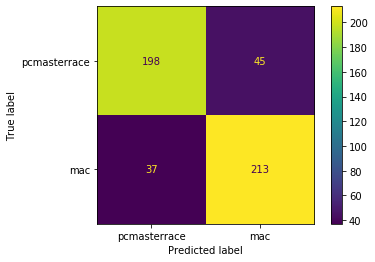

In [73]:
disp = metrics.plot_confusion_matrix(gs, X_test, y_test,
                                    values_format = 'n',
                                    display_labels = ['pcmasterrace','mac'])

- The Multinomial Naive Bayes Model has 213 True Positives and 198 True Negatives, far outweighing the 45 False Positives and 37 False Negatives.

In [106]:
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
spec = tn / (tn + fp)
print(f'Specificity: {round(spec,4)}')
sens = tp / (tp + fn)
print(f'Sensitivity/Recall: {round(sens,4)}')
prec = tp / (tp + fp)
print(f'Precision: {round(prec,4)}')
f1 = (2 * prec * sens)/(prec+sens)
print(f'F1 Score: {round(f1,4)}')
print(f'TN: {round(tn,4)}')
print(f'FP: {round(fp,4)}')
print(f'FN: {round(fn,4)}')
print(f'TP: {round(tp,4)}')

Specificity: 0.8148
Sensitivity/Recall: 0.852
Precision: 0.8256
F1 Score: 0.8386
TN: 198
FP: 45
FN: 37
TP: 213


- As seen from the slightly higher Sensitivity score (85.2%) compared to the Specificity Score (81.48%), our model does a slightly better job of correctly predicting posts relating to the r/mac subreddit as compared to posts relating to the r/pcmasterrace subreddit.
- The model has a reasonably good recall score of 85.2%. However, we will only select this as our best model when there is a high cost associated with False Negative.
- The model has a reasonably good precision score of 82.56%. However, the cost of False Positive in this context is not high. Hence, we will not use this metric as our sole determinor for selecting our best model.
- The model has a reasonably good overall F1 Score of 83.86%. As there is neither a significant cost of False Positive/ False Negative in this business context, the F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

In [21]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in gs.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
pred_df

,true_values,pred_probs
555,0,0.141029
775,0,0.000006
779,0,0.002211
1137,1,0.636866
1767,1,0.386006
...,...,...
206,0,0.264202
27,0,0.010806
372,0,0.143085
1679,1,0.662248


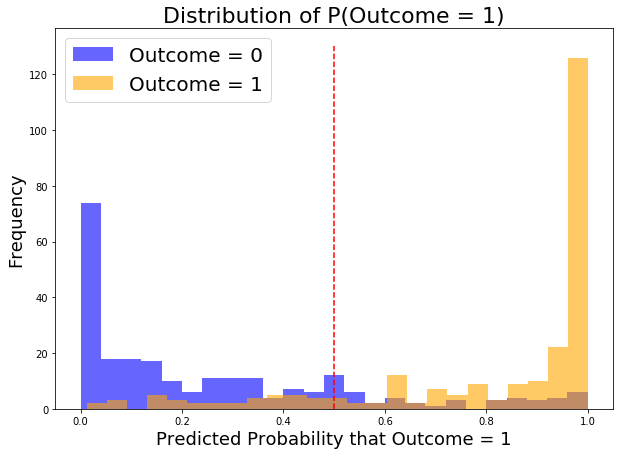

In [81]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 130,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

- This is a graphically representation in the form of a histogram showing that the Multinomial Naive Bayes Model has 213 True Positives and 198 True Negatives, far outweighing the 45 False Positives and 37 False Negatives.

## Logistic Regression Model

In [42]:
#Without Hyperparameters
vectorizer = CountVectorizer(stop_words = ['pc','macbook','mac','imac'],
                            max_features = 4000,
                            ngram_range = (1,1),
                            min_df = 1,
                            max_df = 0.15)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

lr = LogisticRegression()

lr.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(lr,X_train_vec,y_train,cv=5).mean())
print("Train Score: ",lr.score(X_train_vec,y_train))
print("Test Score: ",lr.score(X_test_vec,y_test))

Cross Val Score:  0.8102954649564819
Train Score:  0.9728997289972899
Test Score:  0.8275862068965517


In [48]:
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

lr2 = LogisticRegression(max_iter=1000)

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=lr2,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)
                  
#Fit the model
best_model = grid.fit(X_train_vec,y_train)
                  
#Print The value of best Hyperparameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best penalty: l2
Best C: 1
Best class_weight: {1: 0.4, 0: 0.6}
Best solver: saga


[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.0min finished


In [53]:
lr3 = LogisticRegression(max_iter=1000,
                        penalty='l2',
                        C=1,
                        class_weight={1: 0.4, 0: 0.6},
                        solver='saga',
                        )

lr3.fit(X_train_vec,y_train)
print("Cross Val Score: ",cross_val_score(lr3,X_train_vec,y_train,cv=5).mean())
print("Train Score: ",lr3.score(X_train_vec,y_train))
print("Test Score: ",lr3.score(X_test_vec,y_test))

Cross Val Score:  0.7967498854786991
Train Score:  0.9220867208672087
Test Score:  0.8093306288032455


- The model is overfit with a 92% accuracy in training data.
- The test score was similar to cross validation score (approx. 80%). The model is expected to have 80% accuracy in new data.
- Hyper parameter tuning had a slight improvement in fit compared to the default options. Based on the decrease in difference between the train score and test score from approx. 15% to 12%, the model appears to be better fitted.

In [57]:
# Generate predictions.
preds2 = lr3.predict(X_test_vec)

In [58]:
# Generate confusion matrix.

confusion_matrix(y_test, # True values.
                 preds2)  # Predicted values.

array([[223,  20],
       [ 74, 176]])

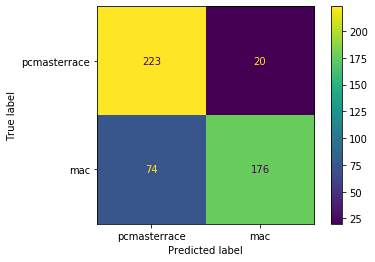

In [60]:
disp = metrics.plot_confusion_matrix(lr3, X_test_vec, y_test,
                                    values_format = 'n',
                                    display_labels = ['pcmasterrace','mac'])

- The Logistic Regression Model has 176 True Positives and 223 True Negatives, far outweighing the 20 False Positives and 74 False Negatives.

In [108]:
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds2).ravel()
spec = tn / (tn + fp)
print(f'Specificity: {round(spec,4)}')
sens = tp / (tp + fn)
print(f'Sensitivity/Recall: {round(sens,4)}')
prec = tp / (tp + fp)
print(f'Precision: {round(prec,4)}')
f1 = (2 * prec * sens)/(prec+sens)
print(f'F1 Score: {round(f1,4)}')
print(f'TN: {round(tn,4)}')
print(f'FP: {round(fp,4)}')
print(f'FN: {round(fn,4)}')
print(f'TP: {round(tp,4)}')

Specificity: 0.9177
Sensitivity/Recall: 0.704
Precision: 0.898
F1 Score: 0.7892
TN: 223
FP: 20
FN: 74
TP: 176


- As seen from the significantly higher Specificity score (91.77%) compared to the Specificity Score (70.4%), our model does a significantly better job of correctly predicting posts relating to the r/pcmasterrace subreddit as compared to posts relating to the r/mac subreddit.
- The model has a comparatively poor recall score of 70.4%. However, we will only select this as our best model when there is a high cost associated with False Negative.
- The model has a extremely good precision score of 89.8%. However, the cost of False Positive in this context is not high. Hence, we will not use this metric as our sole determinor for selecting our best model.
- The model has a decent overall F1 Score of 78.92%. As there is neither a significant cost of False Positive/ False Negative in this business context, the F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

In [62]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba2 = [i[1] for i in lr3.predict_proba(X_test_vec)]

pred_df2 = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba2})
pred_df2

,true_values,pred_probs
555,0,0.324688
775,0,0.026333
779,0,0.140871
1137,1,0.444545
1767,1,0.285833
...,...,...
206,0,0.420872
27,0,0.054851
372,0,0.162568
1679,1,0.437413


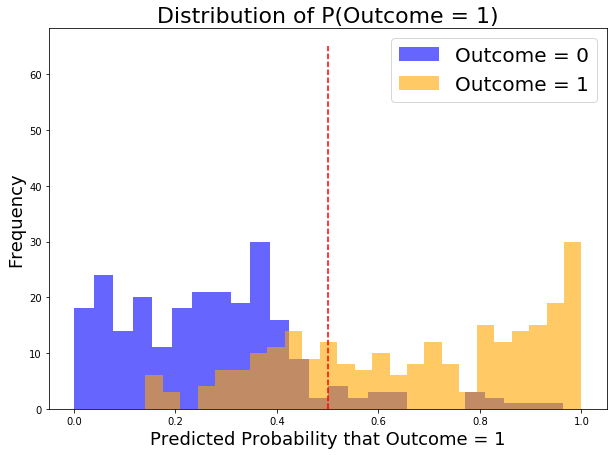

In [74]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df2[pred_df2['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df2[pred_df2['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

- This is a graphically representation in the form of a histogram showing that the Logistic Regression Model has 176 True Positives and 223 True Negatives, far outweighing the 20 False Positives and 74 False Negatives.

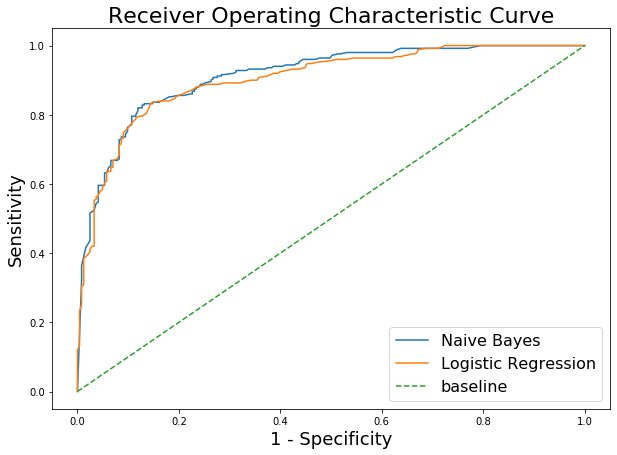

In [82]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

tpr_values2 = [TPR(pred_df2, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values2 = [FPR(pred_df2, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='Naive Bayes')
plt.plot(fpr_values2, # False Positive Rate on X-axis
         tpr_values2, # True Positive Rate on Y-axis
         label='Logistic Regression')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Results:

- Based on our problem statement, the aim is to create a model that is able to generalize well across new observations and accurately predict the origin of the posts from the correct subreddit.
- As there is neither a significant cost of False Positive/ False Negative in this business context, the F1 Score is a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).
- Comparing the F1 Score of the Multinomial Naive Bayes Model (83.86%) and the Logistic Regression Model (78.92%), we can see that the Multinomial Naive Bayes Model is the better model in solving our problem statement. 